# Load Sentinel - 2 Data

## Data Extraction by using API

### Raw Data

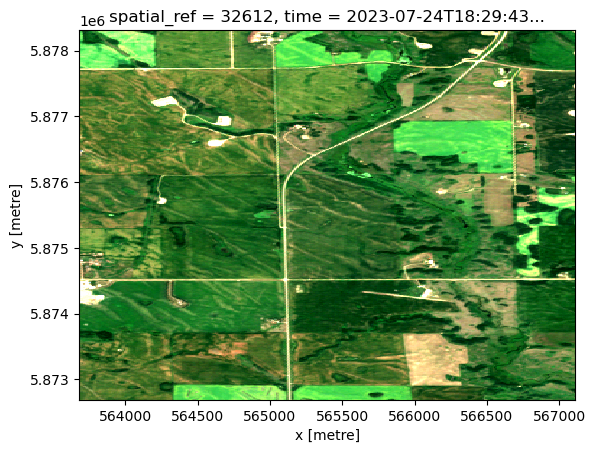

In [80]:
from pystac_client import Client
from odc.stac import load

client = Client.open("https://earth-search.aws.element84.com/v1") # Earth Data From Nasa
collection = "sentinel-2-l2a" # Satelitte 
tas_bbox = [-110, 53, -110.05, 53.05] # Coordinates min lon, min lat, max lo and max lat # 0.1 
search = client.search(collections=[collection], bbox=tas_bbox, datetime="2023-07") # choose a month 53.5 to 53.6 is o.1 degree is about 6 miles in canada

data = load(search.items(), bbox=tas_bbox, groupby="solar_day", chunks={})
data[["red", "green", "blue"]].isel(time=9).to_array().plot.imshow(robust=True) # printing images in Python

# EDA

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Define bounding box coordinates
xmin, ymin, xmax, ymax = -110, 53, -110.05, 53.05

# Create 10 points south to east
south_to_east_points = []
for i in range(10):
    x = xmin + (i * (xmax - xmin) / 9)
    for j in range(10):
        y = ymin + (j * (ymax - ymin) / 9)
        point = Point(x, y)
        south_to_east_points.append(point)

# Create 10 points north to south
north_to_south_points = []
for j in range(10):
    y = ymax - (j * (ymax - ymin) / 9)
    for i in range(10):
        x = xmin + (i * (xmax - xmin) / 9)
        point = Point(x, y)
        north_to_south_points.append(point)

# Create GeoDataFrame for the points
south_to_east_gdf = gpd.GeoDataFrame(geometry=south_to_east_points, crs='EPSG:4326')
north_to_south_gdf = gpd.GeoDataFrame(geometry=north_to_south_points, crs='EPSG:4326')

# Unsupervised Machine Learning - K-Means Clustering

## Ranking Clusters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Assuming data is already loaded and available

# Reshape the image data
image_array = np.stack([data["red"].isel(time=9).values,
                        data["green"].isel(time=9).values,
                        data["blue"].isel(time=9).values], axis=-1)

# Flatten the image array
w, h, d = image_array.shape
image_array_flat = np.reshape(image_array, (w * h, d))

# Perform k-means clustering
n_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(image_array_flat)

# Predict color indices for each pixel
labels = kmeans.predict(image_array_flat)
codebook_random = kmeans.cluster_centers_

# Reshape the labels to the original image shape
labels = labels.reshape(w, h)

# Define a colormap
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF']
cmap = ListedColormap(colors[:n_clusters])

# Plot the clustered image
plt.figure(figsize=(12, 8))
plt.imshow(labels, cmap=cmap)
plt.title('K-Means Clustering')
plt.axis('off')

# Create a custom legend
legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
legend_handles = [Patch(color=colors[i], label=legend_labels[i]) for i in range(n_clusters)]
plt.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from odc.stac import load
from pystac_client import Client
import pandas as pd

# Open the client and search for Sentinel-2 data
client = Client.open("https://earth-search.aws.element84.com/v1")
collection = "sentinel-2-l2a"
tas_bbox = [-110, 53, -110.05, 53.05]
search = client.search(collections=[collection], bbox=tas_bbox, datetime="2023-07")

# Load the data including the NIR band
data = load(search.items(), bands=["red", "green", "blue", "nir"], bbox=tas_bbox, groupby="solar_day", chunks={})

# Choose the time slice
time_index = 11

# Extract the RGB and NIR bands
red = data["red"].isel(time=time_index).values
green = data["green"].isel(time=time_index).values
blue = data["blue"].isel(time=time_index).values
nir = data["nir"].isel(time=time_index).values

# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# Stack the RGB bands to create the image array
image_array = np.stack([red, green, blue], axis=-1)

# Flatten the image array for clustering
w, h, d = image_array.shape
image_array_flat = np.reshape(image_array, (w * h, d))

# Perform k-means clustering
n_clusters = 5  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(image_array_flat)

# Predict cluster labels for each pixel
labels = kmeans.predict(image_array_flat)

# Reshape the labels to the original image shape
labels = labels.reshape(w, h)

# Calculate average NDVI for each cluster
cluster_ndvi = np.zeros(n_clusters)
cluster_counts = np.zeros(n_clusters)

for i in range(n_clusters):
    cluster_ndvi[i] = np.mean(ndvi[labels == i])
    cluster_counts[i] = np.sum(labels == i)

# Rank clusters based on average NDVI
cluster_ranks = np.argsort(cluster_ndvi)[::-1]

# Plot the clustered image with NDVI ranking
plt.figure(figsize=(12, 8))
plt.imshow(labels, cmap='tab10')
plt.title('K-Means Clustering with NDVI Ranking')
plt.axis('off')

# Create a custom legend
import matplotlib.patches as mpatches

legend_labels = [f'Cluster {i+1} (NDVI: {cluster_ndvi[rank]:.2f})' for i, rank in enumerate(cluster_ranks)]
legend_handles = [mpatches.Patch(color=plt.cm.tab10(i), label=legend_labels[i]) for i in range(n_clusters)]
plt.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

# Print the ranked clusters
ranked_clusters = pd.DataFrame({
    'Cluster': np.arange(n_clusters),
    'Average_NDVI': cluster_ndvi,
    'Rank': cluster_ranks + 1
}).sort_values('Rank')

In [82]:
data["nir"].isel(time=time_index).values

array([[5092, 5000, 3796, ..., 4840, 4464, 4092],
       [4888, 4884, 3832, ..., 4596, 4408, 4164],
       [4908, 4932, 4084, ..., 4524, 4400, 4184],
       ...,
       [ 572,  576,  536, ..., 3676, 3632, 3356],
       [ 540,  525,  490, ..., 3604, 3932, 3760],
       [ 513,  486,  450, ..., 3792, 3904, 3688]], dtype=uint16)

In [76]:
data["red"].isel(time=time_index).values

array([[ 814,  544,  371, ...,  718, 1464, 1692],
       [ 880,  667,  404, ..., 1038, 1346, 1546],
       [ 922,  830,  474, ..., 1522, 1556, 1646],
       ...,
       [ 135,  123,  130, ...,  408,  399,  536],
       [ 121,  109,  123, ...,  377,  344,  364],
       [ 123,  116,  119, ...,  354,  322,  356]], dtype=uint16)